## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
# Import everything needed to edit/save/watch video clips
import tensorflow as tf
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
%matplotlib inline

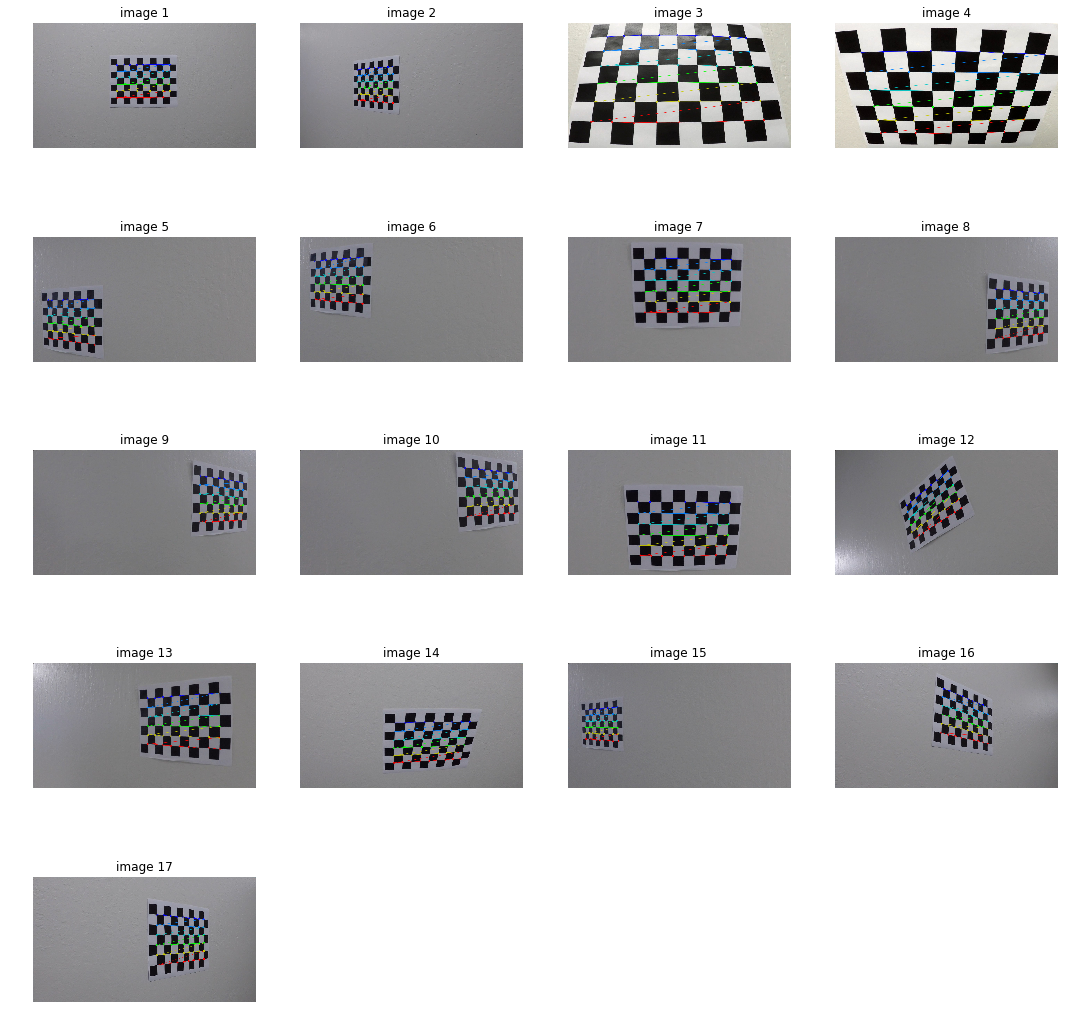

In [3]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# For plotting the output images
gs = gridspec.GridSpec(5,4)
gs.update(wspace=0.01, hspace=0.01) # set the spacing between axes.
plt.figure(figsize=(15,15))

# Step through the list and search for chessboard corners
i = 0
for fname in images:
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)

        ax = plt.subplot(gs[i])
        plt.subplot(5,4,i+1)
        plt.title('image %s'%(i+1))
        plt.imshow(img)
        plt.axis('off')
        i+=1
plt.tight_layout()

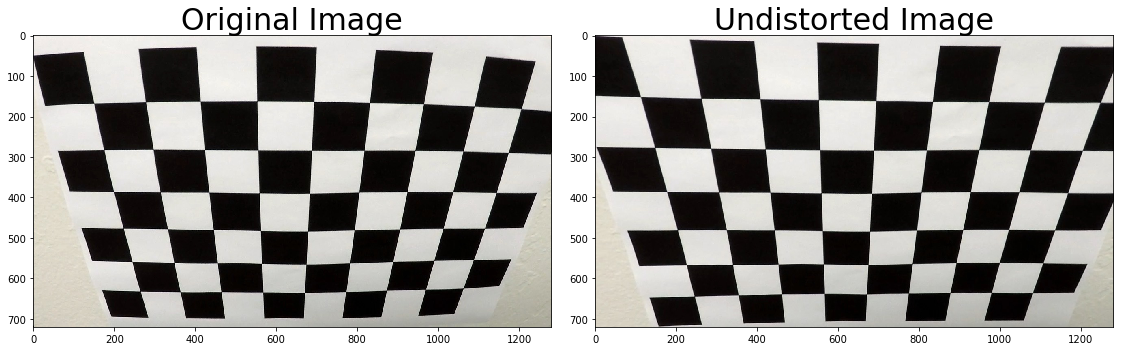

In [4]:
def cal_undistort(img, gray, objpoints, imgpoints, plot=True):
    # Calibrate the camera
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

    # undistort the image
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    if plot:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        f.tight_layout()
        ax1.imshow(img)
        ax1.set_title('Original Image', fontsize=30)
        ax2.imshow(undist)
        ax2.set_title('Undistorted Image', fontsize=30)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        plt.savefig('./examples/undist_chess_board.png')
    
    return mtx, dist

test_chess = mpimg.imread('camera_cal/calibration2.jpg')
gray_test_chess = cv2.cvtColor(test_chess, cv2.COLOR_RGB2GRAY)
mtx, dist = cal_undistort(test_chess, gray_test_chess, objpoints, imgpoints, plot=True)

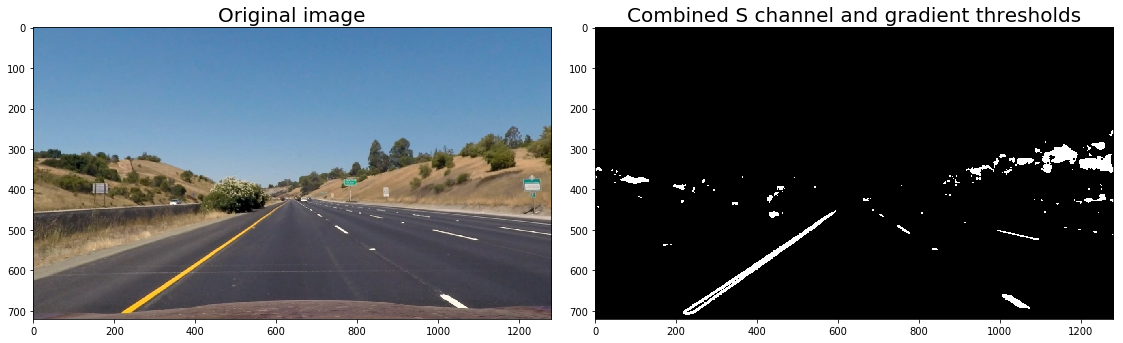

In [5]:
def abs_sobel_thresh(img, orient, sx_thresh=(0, 200)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    elif orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaled_sobel)
    # 6) Return this mask as your binary_output image
    binary_output[(scaled_sobel >= sx_thresh[0])&(scaled_sobel <= sx_thresh[1])] = 1
    return binary_output


def dir_threshold(img, sobel_kernel=3, sdir_thresh=(0, np.pi/2)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx, abs_sobely = np.absolute(sobelx), np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    dirn = np.arctan2(abs_sobely, abs_sobelx) 
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(dirn)
    # 6) Return this mask as your binary_output image
    binary_output[(dirn >= sdir_thresh[0])&(dirn <= sdir_thresh[1])] = 1
    return binary_output


# Color transforms, gradients to create  thresholded binary image
def threshold_binary(img, plot=True):
    #s_channel = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)[:,:,2]
    
    l_channel = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)[:,:,0]

    b_channel = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)[:,:,2]   

    # Threshold color channel
    b_thresh_min = 155
    b_thresh_max = 200
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thresh_min) & (b_channel <= b_thresh_max)] = 1
    
    l_thresh_min = 225
    l_thresh_max = 255
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1
    
    combined_binary = np.zeros_like(b_binary)
    combined_binary[(l_binary == 1) | (b_binary == 1)] = 1
    
    kernel = np.ones((3,3),np.uint8)
    dilated_combined_binary = cv2.dilate(combined_binary,kernel,iterations = 1)
    
    if plot:
        # Plot the result
        f, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 5))
        f.tight_layout()

        ax1.imshow(img)
        ax1.set_title('Original image', fontsize=20)

        ax2.imshow(dilated_combined_binary, cmap = 'gray')
        ax2.set_title('Combined S channel and gradient thresholds', fontsize=20)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        plt.savefig('examples/thresholded_binary_image.png')
    #return dilation
    return dilated_combined_binary

test_images = glob.glob('test_images/straight_lines1.jpg')

for img_num in test_images:
    test_img = mpimg.imread(img_num)
    #gray = cv2.cvtColor(test_img, cv2.COLOR_RGB2GRAY)
    undistorted = cv2.undistort(test_img, mtx, dist, None, mtx)
    combined = threshold_binary(undistorted)

(720, 1280, 3)


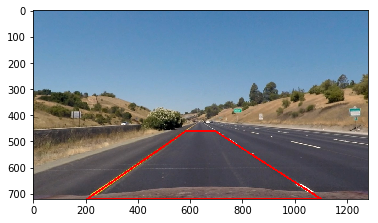

In [6]:
plt.imshow(undistorted)
undist_copy = np.copy(undistorted)
undist_size = undistorted.shape
print(undist_size)
pts = np.array([[(undist_size[1] / 2) - 55, undist_size[0] / 2 + 100],
                     [((undist_size[1] / 5) - 50), undist_size[0]],
                     [(undist_size[1] * 5 / 6) + 35, undist_size[0]],
                     [(undist_size[1] / 2 + 55), undist_size[0] / 2 + 100]], np.int32)
pts = pts.reshape((-1,1,2))
cv2.polylines(undist_copy, [pts], True, (255,0,0), 5)
plt.imshow(undist_copy)

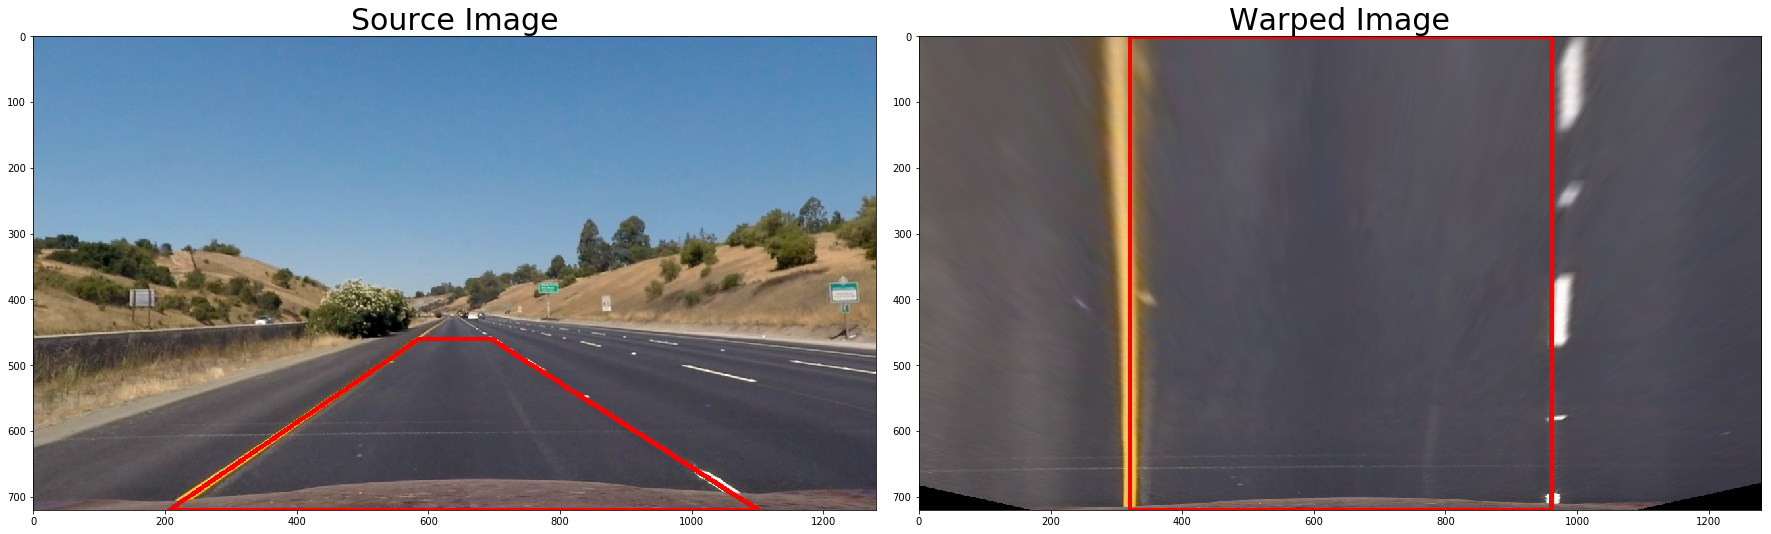

In [7]:
def warp(img, plot=True):
    img_size = (img.shape[1], img.shape[0])
    
    src = np.float32([[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
                     [((img_size[0] / 5) - 50), img_size[1]],
                     [(img_size[0] * 5 / 6) + 35, img_size[1]],
                     [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
    
    dst = np.float32([[(img_size[0] / 4), 0],
                     [(img_size[0] / 4), img_size[1]],
                     [(img_size[0] * 3 / 4), img_size[1]],
                     [(img_size[0] * 3 / 4), 0]])
    
    # Compute the perspective transform, M
    M = cv2.getPerspectiveTransform(src, dst)
    
    M_inv = cv2.getPerspectiveTransform(dst, src)
    
    # Create warped image
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    warped_copy, im_copy = np.copy(warped), np.copy(img)
    
    # Plotting
    if plot:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        pts = np.array([[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
                     [((img_size[0] / 5)) - 50, img_size[1]],
                     [(img_size[0] * 5 / 6) + 35, img_size[1]],
                     [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]], np.int32)
        pts = pts.reshape((-1,1,2))
        cv2.polylines(im_copy, [pts], True, (255,0,0), 5)
        ax1.imshow(im_copy)
        ax1.set_title('Source Image', fontsize=30)
        cv2.rectangle(warped_copy,(img_size[0] // 4, 0),((img_size[0] * 3 )// 4, img_size[1]),(255,0,0),5)
        ax2.imshow(warped_copy)
        ax2.set_title('Warped Image', fontsize=30)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        plt.savefig('examples/warped_image.png')
        
    
    return warped, M_inv

warped_image, M_inv = warp(undistorted, plot=True)

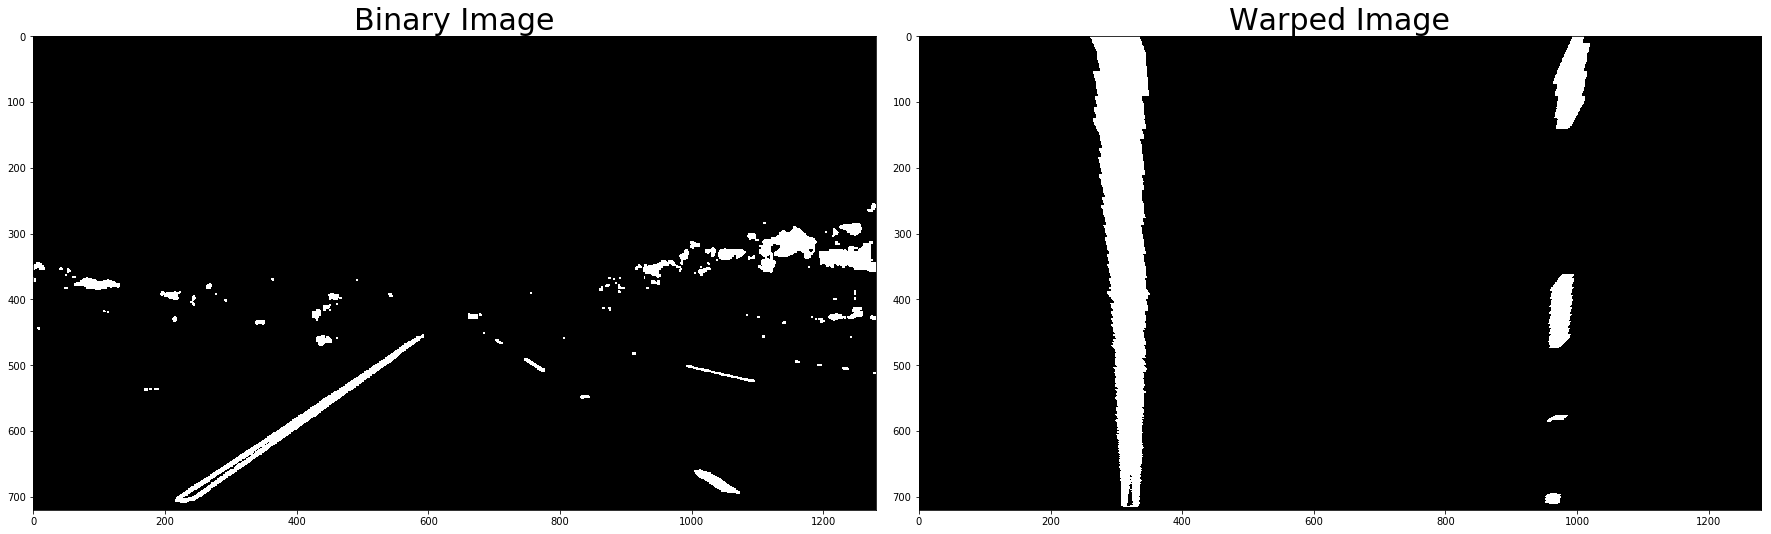

In [8]:
binary_warped, M_inv = warp(combined, plot=False)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(combined, cmap='gray')
ax1.set_title('Binary Image', fontsize=30)
ax2.imshow(binary_warped, cmap='gray')
ax2.set_title('Warped Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('examples/warped_binary_image.png')

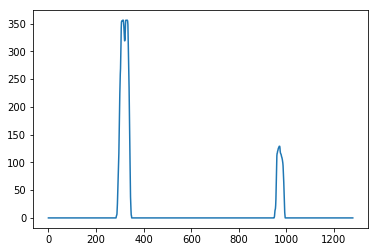

In [9]:
import numpy as np
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)
plt.savefig('examples/histogram.png')

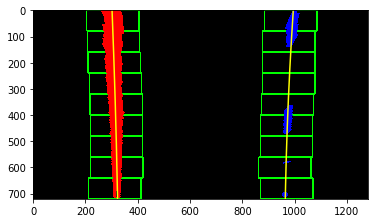

In [10]:
# Assuming you have created a warped binary image called "binary_warped"
# Create an output image to draw on and  visualize the result
def sliding_window_search(binary_warped, plot=True):
    # create the output image for visualization
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        ## Draw the windows on the visualization image
        if plot:
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 4) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 4) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    if plot:
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        out_img[lefty, leftx] = [255, 0, 0]
        out_img[righty, rightx] = [0, 0, 255]
        plt.imshow(out_img)

        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        plt.savefig('examples/sliding_windows.png')
        
    return left_fit, right_fit

left_fit, right_fit = sliding_window_search(binary_warped, plot=True)

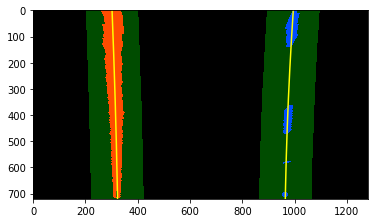

In [11]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
def margin_search(binary_warped, left_fit, right_fit, plot=True):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    if plot:
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[lefty, leftx] = [255, 0, 0] # Red
        out_img[righty, rightx] = [0, 0, 255] # Blue

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        plt.savefig('examples/margin_search.png')
        
    return left_fit, right_fit

left_fit, right_fit = margin_search(binary_warped, left_fit, right_fit, plot=True)

In [12]:
def radius_curvature(ploty, left_fitx, right_fitx):
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    return left_curverad, right_curverad, left_fit_cr, right_fit_cr

def center_offset(left_fitx, right_fitx):
    #print(len(rightx), len(leftx))
    # Calculate the position of the vehicle
    lane_center = (right_fitx[719] + left_fitx[719])/2
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    center_offset_pixels = abs(640 - lane_center)
    center_offset_m = xm_per_pix*center_offset_pixels
    return center_offset_m

ploty = ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

left_curverad, right_curverad, left_fit_cr, right_fit_cr = radius_curvature(ploty, left_fitx, right_fitx)
avg_rad_curvature = (left_curverad + right_curverad)/2
rad_curvature_text = 'Radius of Curvature: %.2f m' %avg_rad_curvature
print(rad_curvature_text)

center_offset_m = center_offset(left_fitx, right_fitx)
center_offset_text = "Center offset: %.2f m" %center_offset_m
print(center_offset_text)

Radius of Curvature: 7996.71 m
Center offset: 0.02 m


In [13]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        self.n_frames = 10
        
        # was the line detected in the last iteration?
        self.detected = False  
        
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        
        #polynomial coefficients averaged over the last n iterations
        self.best_left_fit = None
        self.best_right_fit = None
        
        #polynomial coefficients for the most recent fit
        self.current_left_fit = [] 
        self.current_right_fit = []
        
        #radius of curvature of the line in some units
        self.left_curvature = None
        self.right_curvature = None
        self.radius_of_curvature = None 
        
        #distance in meters of vehicle center from the line
        self.offset_from_center = None 
        
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        
        #x values for detected line pixels
        self.allx = None  
        
        #y values for detected line pixels
        self.ally = None
        
    def sanity_check(self, image, left_fit, right_fit):    
        ploty = np.linspace(0, image.shape[0]-1, image.shape[0])
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
        left_curverad, right_curverad, left_fit_cr, right_fit_cr = radius_curvature(ploty, left_fitx, right_fitx)
        
        # check if the lines have similar curvature
        ratio = left_curverad/right_curverad
        
        if ratio > 10 or ratio < 0.1:
            return False
        
        # check it the lines are separated by the right distance
        dev_dist = 300
        valid_dist = 800
        curr_dist = right_fitx[-1] - left_fitx[-1]
        if (np.abs(curr_dist - valid_dist) > dev_dist):
            return False
        
        # check if lines are roughly parallel
        lines_dev = 100
        dist = right_fitx - left_fitx
        dev = np.std(dist)
        if (dev >= lines_dev):
            return False
            
        return True
    
    def find_lane_lines(self, binary_warped):
        if self.detected:
            previous_left_fit = self.current_left_fit[-1]
            previous_right_fit = self.current_left_fit[-1]
            # search lane for finding the binary image and margin
            left_fit, right_fit = margin_search(binary_warped, previous_left_fit, previous_right_fit, plot=False)
        else:
            left_fit, right_fit = sliding_window_search(binary_warped, plot=False)
            
        #if len(left_fit) != 0 and len(right_fit) != 0:
        self.current_left_fit.append(left_fit)
        self.current_right_fit.append(right_fit)
                
        # Keep the last N iterations
        if len(self.current_left_fit) > self.n_frames:
            self.current_left_fit = self.current_left_fit[-self.n_frames:]
            self.current_right_fit = self.current_right_fit[-self.n_frames:]
            
        # average
        self.best_left_fit = np.mean(self.current_left_fit, axis=0)
        self.best_right_fit = np.mean(self.current_right_fit, axis=0)
        
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
        # Calculate radius of curvature and center offset
        self.left_curvature, self.right_curvature, left_fit_cr, right_fit_cr = radius_curvature(ploty, left_fitx, right_fitx)
        self.radius_of_curvature = (self.left_curvature + self.right_curvature)/2
        self.offset_from_center = center_offset(left_fitx, right_fitx)
        
        return left_fitx, right_fitx
    
    def get_lane_lines(self):
        return self.best_left_fit, self.best_right_fit
    
    def get_radius_curvature(self):
        return self.left_curvature, self.right_curvature, self.radius_of_curvature
    
    def get_center_offset(self):
        return self.offset_from_center

In [14]:
def draw_lane_lines(undistorted, left_fitx, right_fitx, M_inv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    ploty = np.linspace(0, undistorted.shape[0]-1, undistorted.shape[0])
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.polylines(color_warp, np.int_(pts_left), isClosed=False, color=(255,0,0), thickness=40)
    cv2.polylines(color_warp, np.int_(pts_right), isClosed=False, color=(0,0,255), thickness=40)
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, M_inv, (undistorted.shape[1], undistorted.shape[0]), flags=cv2.INTER_LINEAR) 
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
    
    return result

In [15]:
line = Line()

left_fit, right_fit = line.find_lane_lines(binary_warped)
left_curvature, right_curvature, radius_of_curvature = line.get_radius_curvature()
offset_from_center = line.get_center_offset()

result = draw_lane_lines( undistorted, left_fit, right_fit, M_inv)


In [16]:
def add_curvature_and_offset(result, left_curvature, right_curvature, radius_of_curvature, center_offset_m):
    #left_curverad, right_curverad, left_fit_cr, right_fit_cr = radius_curvature(ploty, left_fitx, right_fitx)
    avg_rad_curvature = (left_curvature + right_curvature)/2
    rad_curvature_text = 'Radius of Curvature: %.2f m' %avg_rad_curvature
    
    center_offset_text = "Center offset: %.2f m" % center_offset_m
    
    cv2.putText(img=result, text=rad_curvature_text, org=(200,70),fontFace=2, fontScale=1.5, color=(255,255,255), thickness=3)
    cv2.putText(img=result, text=center_offset_text, org=(300,130),fontFace=2, fontScale=1.5, color=(255,255,255), thickness=3)
    return result

In [17]:
# Draw the region on the image
def final_image(undistorted, line):
    left_fit, right_fit = line.get_lane_lines()
    left_rad_curvature, right_rad_curvature, avg_rad_curvature = line.get_radius_curvature()
    offset = line.get_center_offset()
    
    ploty = np.linspace(0,undistorted.shape[0]-1, undistorted.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
    result = draw_lane_lines(undistorted, left_fitx, right_fitx, M_inv)
    result = add_curvature_and_offset(result, left_rad_curvature, right_rad_curvature, avg_rad_curvature, offset)
    return result   

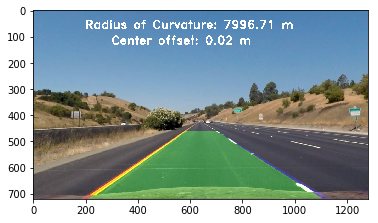

In [18]:
result = final_image(undistorted, line)
plt.imshow(result)
plt.savefig('output_images/final_image.png')

### Process Pipeline
1. Undistort the image
2. Apply color and gradient thresholding
3. Apply perspective transform to get a bird's eyeviwe image
4. Detect lane lines using the Sliding window search technique
5. Measure the curvature and offset

In [19]:
# create an object from the Line class
line = Line()

def process_image(image):
    undistorted_image = cv2.undistort(image, mtx, dist, None, mtx)
    thresholded_image = threshold_binary(undistorted_image, plot=False)
    warped_image, M_inv = warp(thresholded_image, plot=False)
    #plt.imshow(warped_image, cmap='gray')
    left_fit, right_fit = line.find_lane_lines(warped_image)
    #plt.imshow(lane_image)
    result = final_image(undistorted_image, line)
    return result

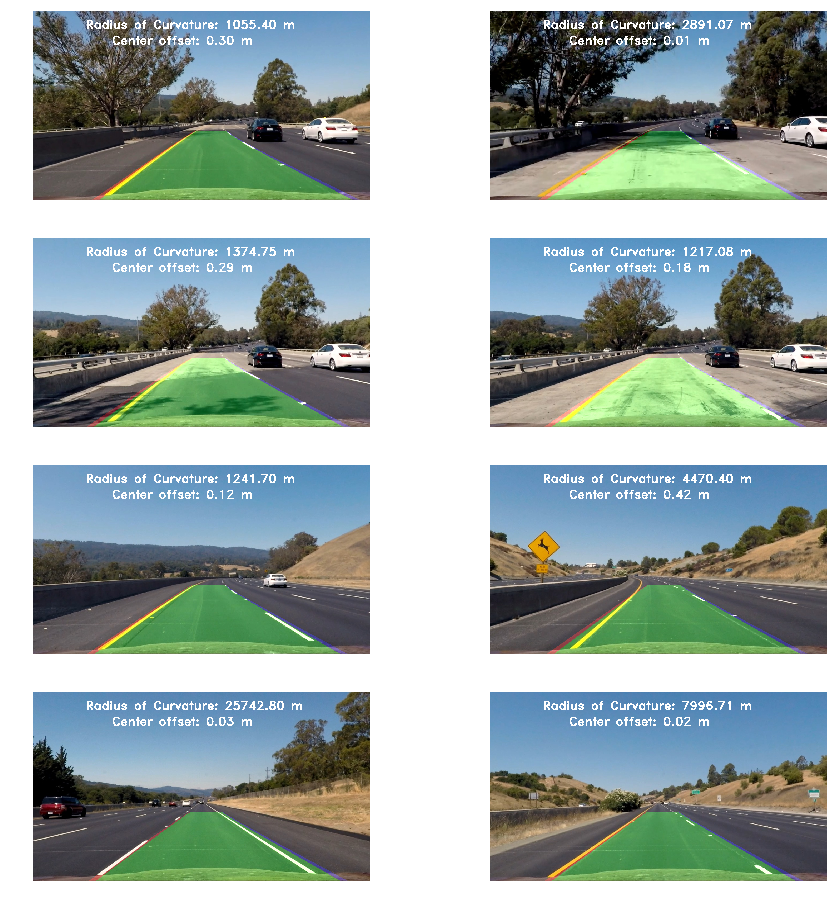

In [20]:
images = glob.glob('test_images/*.jpg')
plt.figure(figsize=(15,16))
i = 1
for test_img in images:
    test_img = mpimg.imread(test_img)
    out = process_image(test_img)
    plt.subplot(4,2,i)
    plt.imshow(out)
    plt.axis('off')
    i += 1
    #plt.imshow(out)
plt.savefig('output_images/test_images_out.png')

In [21]:
line = Line()

video_1_output = 'project_video_out.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
project_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time project_clip.write_videofile(video_1_output, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [03:00<00:00,  7.50it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 3min 49s, sys: 15.8 s, total: 4min 4s
Wall time: 3min 2s


In [22]:
my_clip = VideoFileClip("project_video_out.mp4").resize(width=480).subclip(0,5)
my_clip.write_gif("output_images/sample.gif", fps=25)


[MoviePy] Building file output_images/sample.gif with imageio


 99%|█████████▉| 125/126 [00:16<00:00,  7.36it/s]


In [23]:
"""
challenge_image = mpimg.imread('challenge_video_image.jpg')
undistorted = cv2.undistort(challenge_image, mtx, dist, None, mtx)
binary_image = threshold_binary(undistorted)
plt.imshow(binary_image, cmap='gray')
plt.show()
"""

"\nchallenge_image = mpimg.imread('challenge_video_image.jpg')\nundistorted = cv2.undistort(challenge_image, mtx, dist, None, mtx)\nbinary_image = threshold_binary(undistorted)\nplt.imshow(binary_image, cmap='gray')\nplt.show()\n"

In [24]:
"""
line = Line()

video_2_output = 'challenge_video_out.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip2 = VideoFileClip("challenge_video.mp4").subclip(0,5)
challenge_clip = clip2.fl_image(process_image) #NOTE: this function expects color images!!
%time challenge_clip.write_videofile(video_2_output, audio=False)
"""

'\nline = Line()\n\nvideo_2_output = \'challenge_video_out.mp4\'\n## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video\n## To do so add .subclip(start_second,end_second) to the end of the line below\n## Where start_second and end_second are integer values representing the start and end of the subclip\n## You may also uncomment the following line for a subclip of the first 5 seconds\n##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)\nclip2 = VideoFileClip("challenge_video.mp4").subclip(0,5)\nchallenge_clip = clip2.fl_image(process_image) #NOTE: this function expects color images!!\n%time challenge_clip.write_videofile(video_2_output, audio=False)\n'